<a href="https://colab.research.google.com/github/nravinuthala/EIPAssignments/blob/master/Assignment5/PersonAttrubutes_Nagaraj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Depth = 4 (Receptive field of 11 before reducing size of feature map)
#Stages = 5 (Total receptive field of 251)
Resnet38v2
Using lr scheduler

(to try: cyclic lr, changing neck per label, loss weights per label)

In [2]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.utils import plot_model
from keras.applications import VGG16
from keras.layers import DepthwiseConv2D
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Conv2D, BatchNormalization, Activation, AveragePooling2D
from keras.regularizers import l2
import os
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

# Hyper Params

In [0]:
epochs = 10
init_lr = 1.0
momentum = 0.9
batch_size = 64

In [6]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

gender imagequality    age  ...        emotion        bodypose     image_path
0    male      Average  35-45  ...        Neutral  Front-Frontish  resized/1.jpg
1  female      Average  35-45  ...  Angry/Serious  Front-Frontish  resized/2.jpg
2    male         Good  45-55  ...        Neutral  Front-Frontish  resized/3.jpg
3    male         Good  45-55  ...        Neutral  Front-Frontish  resized/4.jpg
4  female         Good  35-45  ...        Neutral  Front-Frontish  resized/5.jpg

[5 rows x 9 columns]

In [8]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T
#one_hot_df.columns

0  ...              4
image_path                            resized/1.jpg  ...  resized/5.jpg
gender_female                                     0  ...              1
gender_male                                       1  ...              0
imagequality_Average                              1  ...              0
imagequality_Bad                                  0  ...              0
imagequality_Good                                 0  ...              1
age_15-25                                         0  ...              0
age_25-35                                         0  ...              0
age_35-45                                         1  ...              1
age_45-55                                         0  ...              0
age_55+                                           0  ...              0
weight_normal-healthy                             1  ...              0
weight_over-weight                                0  ...              0
weight_slightly-overweight                        0  ...              1
weight_underweight                                0  ...              0
carryingbag_Daily/Office/Work Bag                 0  ...              0
carryingbag_Grocery/Home/Plastic Bag              1  ...              0
carryingbag_None                                  0  ...              1
footwear_CantSee                                  0  ...              1
footwear_Fancy                                    0  ...              0
footwear_Normal                                   1  ...              0
emotion_Angry/Serious                             0  ...              0
emotion_Happy                                     0  ...              0
emotion_Neutral                                   1  ...              1
emotion_Sad                                       0  ...              0
bodypose_Back                                     0  ...              0
bodypose_Front-Frontish                           1  ...              1
bodypose_Side                                     0  ...              0

[28 rows x 5 columns]

In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

In [0]:
class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        images = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])        
        if self.augmentation is not None:
            images = self.augmentation.flow(images, shuffle=False).next()
        
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        
        return images, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [16]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state=1)
train_df.shape, val_df.shape
val_df.head()

image_path  gender_female  ...  bodypose_Front-Frontish  bodypose_Side
2450    resized/2451.jpg              1  ...                        0              0
2743    resized/2744.jpg              1  ...                        0              1
12207  resized/12209.jpg              1  ...                        1              0
3931    resized/3932.jpg              1  ...                        1              0
994      resized/995.jpg              1  ...                        1              0

[5 rows x 28 columns]

In [0]:
train_df.head()

image_path  gender_female  ...  bodypose_Front-Frontish  bodypose_Side
9890  resized/9891.jpg              0  ...                        1              0
4576  resized/4577.jpg              0  ...                        1              0
8017  resized/8018.jpg              0  ...                        1              0
3913  resized/3914.jpg              0  ...                        0              0
1510  resized/1511.jpg              0  ...                        0              1

[5 rows x 28 columns]

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
'''
featurewise_center=True,
featurewise_std_normalization=True,
'''
aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=get_random_eraser(v_l=1, v_h=1))

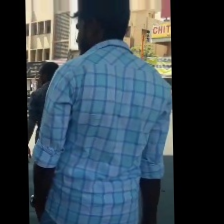

In [20]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, 
                                batch_size=24, 
                                shuffle=True,
                                augmentation=aug)

valid_gen = PersonDataGenerator(val_df, batch_size=32, shuffle=False)
cv2_imshow(train_gen[0][0][0])
#print(train_gen[0][0][0][0])

In [21]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
n = 4

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v2(input_shape, depth, num_classes=27):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(5):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=1)(x)
    #y = Flatten()(x)
    y = (x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 224, 224, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_62 (BatchNo (None, 224, 224, 16) 64          conv2d_67[0][0]                  
__________________________________________________________________________________________________
activation_62 (Activation)      (None, 224, 224, 16) 0           batch_normalization_62[0][0]     
____________________________________________________________________________________________

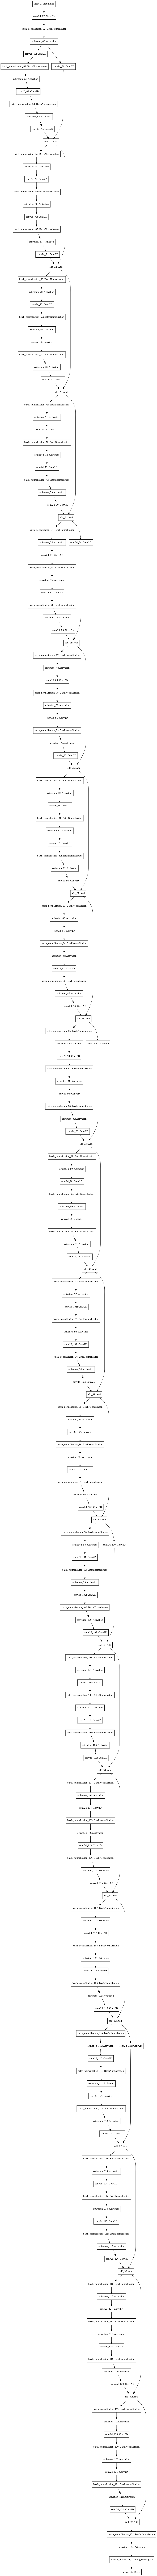

In [0]:
input_shape = (224, 224, 3)
resnet_v2_x = resnet_v2(input_shape=input_shape, depth=depth)
'''model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])'''
resnet_v2_x.summary()
print(model_type)
from keras.utils import plot_model
plot_model(resnet_v2_x)

In [0]:
# Prepare model model saving directory.
#save_dir = os.path.join(os.getcwd(), 'saved_models')
save_dir = '/content/gdrive/My Drive/saved models'
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    #lr = 1e-3
    lr = 5.0
    if epoch > 10:
        lr *= 0.5e-3
    elif epoch > 8:
        lr *= 1e-3
    elif epoch > 6:
        lr *= 1e-2
    elif epoch > 5:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             mode='min',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [0]:
'''backbone = VGG16(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)'''

backbone = resnet_v2_x
#print("Inputs : ", backbone.input)
neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)

def build_tower(in_layer):
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(neck)
    neck = Dense(256, activation="relu")(neck)
    neck = Dropout(0.3)(neck)
    neck = Dense(512, activation="relu")(neck)
    #neck = Dropout(0.1)(neck)
    neck = Dense(1024)(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))

model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)
model.summary()
plot_model(model, show_shapes=True)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 224, 224, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_62 (BatchNo (None, 224, 224, 16) 64          conv2d_67[0][0]                  
__________________________________________________________________________________________________
activation_62 (Activation)      (None, 224, 224, 16) 0           batch_normalization_62[0][0]     
____________________________________________________________________________________________

In [0]:
# freeze backbone
#for layer in backbone.layers:
#	layer.trainable = False

In [0]:
 '''
 {'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}
 '''
 losses = {
 	"age_output": "categorical_crossentropy",
	 "bag_output": "categorical_crossentropy",
	 "emotion_output": "categorical_crossentropy",
	 "footwear_output": "categorical_crossentropy",
	 "gender_output": "binary_crossentropy",
 	"image_quality_output": "categorical_crossentropy",
 	"pose_output": "categorical_crossentropy",
	"weight_output": "categorical_crossentropy"
 }
 loss_weights = {"age_output": 2.0,
                 "bag_output": 2.0,
	 							 "emotion_output": 2.0,
	 							 "footwear_output": 2.0,
	 							 "gender_output": 2.0,
 								 "image_quality_output": 2.0,
 								 "pose_output": 2.0,
								 "weight_output": 2.0}
opt = SGD(lr=0.001, momentum=0.9)


# Model Compile

In [0]:
model.compile(
    optimizer=opt,
    #loss="categorical_crossentropy", 
    loss=losses,
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)

# Model Fit

In [0]:
'''model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    verbose=1)'''
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    epochs=200,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/200
Learning rate:  0.001
480/480 [==============================] - 315s 656ms/step - loss: 19.0859 - gender_output_loss: 0.6833 - image_quality_output_loss: 0.9799 - age_output_loss: 1.4243 - weight_output_loss: 0.9840 - bag_output_loss: 0.9119 - footwear_output_loss: 0.9687 - pose_output_loss: 0.9269 - emotion_output_loss: 0.8977 - gender_output_acc: 0.5621 - image_quality_output_acc: 0.5529 - age_output_acc: 0.4041 - weight_output_acc: 0.6349 - bag_output_acc: 0.5666 - footwear_output_acc: 0.5422 - pose_output_acc: 0.6185 - emotion_output_acc: 0.7162 - val_loss: 19.1866 - val_gender_output_loss: 0.6760 - val_image_quality_output_loss: 0.9796 - val_age_output_loss: 1.4384 - val_weight_output_loss: 0.9800 - val_bag_output_loss: 0.9321 - val_footwear_output_loss: 0.9348 - val_pose_output_loss: 0.9270 - val_emotion_output_loss: 0.9608 - val_gender_output_acc: 0.5645 - val_image_quality_output_acc: 0.5536 - val_age_output_acc: 0.3656 - val_weight_output_acc: 0.6399 - val_bag_out

In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive')
from keras.models import load_model
best_model_so_far = load_model("/content/gdrive/My Drive/saved models/cifar10_ResNet38v2_model.133.h5")


In [30]:
results = best_model_so_far.evaluate_generator(valid_gen, verbose=1)
dict(zip(best_model_so_far.metrics_names, results))

63/63 [==============================] - 25s 396ms/step


{'age_output_acc': 0.3888888888888889,
 'age_output_loss': 1.3817602679842995,
 'bag_output_acc': 0.6165674603174603,
 'bag_output_loss': 0.8449853204545521,
 'emotion_output_acc': 0.685515873015873,
 'emotion_output_loss': 0.9089411534960308,
 'footwear_output_acc': 0.6403769841269841,
 'footwear_output_loss': 0.7969424611046201,
 'gender_output_acc': 0.8586309523809523,
 'gender_output_loss': 0.34351532042972627,
 'image_quality_output_acc': 0.5689484126984127,
 'image_quality_output_loss': 0.9172874499881079,
 'loss': 16.33228327736022,
 'pose_output_acc': 0.7901785714285714,
 'pose_output_loss': 0.5220622425041501,
 'weight_output_acc': 0.6408730158730159,
 'weight_output_loss': 0.9427454868952433}

In [36]:
best_model_so_far.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    epochs=10,
    verbose=1,
    callbacks=callbacks)


Epoch 1/10
Learning rate:  0.001
  3/480 [..............................] - ETA: 5:50 - loss: 16.9866 - gender_output_loss: 0.4554 - image_quality_output_loss: 0.9315 - age_output_loss: 1.3337 - weight_output_loss: 1.0299 - bag_output_loss: 0.8838 - footwear_output_loss: 0.7281 - pose_output_loss: 0.7538 - emotion_output_loss: 0.8828 - gender_output_acc: 0.8056 - image_quality_output_acc: 0.5000 - age_output_acc: 0.4722 - weight_output_acc: 0.6250 - bag_output_acc: 0.5972 - footwear_output_acc: 0.6528 - pose_output_acc: 0.6389 - emotion_output_acc: 0.6944

KeyboardInterrupt: ignored

In [0]:
best_model_so_far.save('/content/gdrive/My Drive/saved models/cifar10_ResNet38v2_model.133.h5')